In [1]:
import cv2
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader
import os
import numpy as np

## Data Loading

In [ ]:
path = "../Data/images_original/metal/metal00000.png"
obs = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
obs = obs[35:-36:, 54:-43]
obs = torch.from_numpy(obs)
obs = torch.reshape(obs, (1,1,217,335))
obs = obs.to(dtype = torch.float32)

In [8]:
class_dict = {'blues' : 0,
              'classical': 1,
              'country': 2,
              'disco' : 3,
              'hiphop' : 4,
              'jazz' : 5,
              'metal' : 6,
              'pop' : 7,
              'reggae': 8,
              'rock' : 9    
}

In [109]:
def collect_data():
    data = []
    # Collect all images from the 10 genres
    for genre in os.listdir("../Data/images_original"):
        for image in os.listdir("../Data/images_original/" + genre):
            image_path = "../Data/images_original/" + genre + "/" + image
            grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            grayscale_img = grayscale_img[35:-36:, 54:-43]
            grayscale_img = torch.tensor(grayscale_img).to(dtype = torch.float32).clone().detach().requires_grad_(True)  #.requires_grad(True)
            #grayscale_img = torch.tensor(grayscale_img, requires_grad=True)
            # Splitting each image vertically into 5 different parts
            for i in range(5):
                # The data loader adds a dimension so I've removed a dimension from the image and class
                data.append((grayscale_img[ : ,  (67*i):67*(i+1)].reshape(1,217,67), torch.tensor(class_dict.get(genre)))) #.reshape(1)))
            
    return data         


In [110]:
data = collect_data()

In [111]:
len(data)

4995

In [112]:
data[500]   #[0].shape

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [16., 74., 66.,  ..., 32., 44., 25.],
          [16., 74., 66.,  ..., 32., 44., 25.],
          [ 6., 26., 20.,  ...,  3.,  0.,  0.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor(1))

In [113]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

train_dataset[2]

(tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [130., 118., 116.,  ...,   0.,   0.,   0.],
          [130., 118., 116.,  ...,   0.,   0.,   0.],
          [ 62.,   1.,   0.,  ...,   2.,   0.,   0.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor(8))

In [114]:
# Get data in dataloader format
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [115]:
next(iter(test_loader))

[tensor([[[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           ...,
           [119., 171., 135.,  ..., 164., 156.,  86.],
           [119., 171., 135.,  ..., 164., 156.,  86.],
           [ 74.,   3.,  36.,  ...,  95.,  63.,  14.]]],
 
 
         [[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           ...,
           [  2.,  28.,   0.,  ...,  27.,  31.,  32.],
           [  2.,  28.,   0.,  ...,  27.,  31.,  32.],
           [ 32.,  24.,  28.,  ...,  36.,  44.,  36.]]],
 
 
         [[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           ...,
           [ 92.,  99.,  91.,  ..., 156.,  92., 100.],
           [ 92.,  99.,  91.,  ..., 156.,  92., 100.],
     

## First CNN

In [ ]:
'''
Parameters
'''

epochs = 50
lr = 0.1
batch_size = 10

'''
Net

'''

net = nn.Sequential(

    nn.Conv2d(1, 32, kernel_size=3, padding = "same"), nn.Sigmoid(),
 
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding = "same"), nn.ReLU(),
 
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding = "same"), nn.Dropout(0.1), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size=2, stride = 2),
    
    nn.Conv2d(256, 512, kernel_size = 2, padding = "same"), nn.Sigmoid(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(512, 1024, kernel_size = 3, padding = "same"), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(1024, 2048, kernel_size = 3, padding = "same"), nn.Sigmoid(),
    
    nn.Flatten(),
    
    nn.Linear(30720, 5000), nn.Dropout(0.2), nn.ReLU(),
    
    nn.Linear(5000, 4096), nn.Sigmoid(),
    
    nn.Linear(4096, 512), nn.Sigmoid(),
    
    nn.Linear(512, 64), nn.ReLU(),
    
    nn.Linear(64, 10), nn.Sigmoid(),
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

'''
Trainer
'''

trainer = torch.optim.Adam(net.parameters(), lr=lr)



# Sandbox net 
## Do whatever you want with this

In [ ]:
'''
Parameters
'''

epochs = 50
lr = 0.1
batch_size = 10

'''
Net

'''

net1 = nn.Sequential(

    nn.Conv2d(1, 16, kernel_size=2, padding = "same"), nn.Sigmoid(),
 
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=2, padding = "same"), nn.Dropout(0.1), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 128, kernel_size = 2, padding = "same"), nn.Dropout(0.1), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=2, stride = 2),
    
    nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(256, 1024, kernel_size = 2, padding = "same"), nn.Dropout(0.2), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(1024, 2048, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.Flatten(),
    
    nn.Linear(122880, 20000), nn.Dropout(0.2), nn.ReLU(),
    
    nn.Linear(512, 128), nn.ReLU(),
    
    nn.Linear(128, 10), nn.ReLU()
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

#loss = nn.KLDivLoss(reduction='none')


'''
Trainer
'''

trainer = torch.optim.Adam(net1.parameters(), lr=lr)



In [ ]:
'''
Parameters
'''

epochs = 5
lr = 0.1
batch_size = 10

'''
Net

'''

net2 = nn.Sequential(

    nn.Conv2d(1, 16, kernel_size=4, padding = "same"), nn.Sigmoid(),
 
    nn.MaxPool2d(kernel_size=4, stride=4),

    nn.Conv2d(16, 32, kernel_size=4, padding = "same"), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=4, stride=4),
    
    nn.Conv2d(32, 64, kernel_size =4, padding = "same"), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=4, stride = 4),
    
    #nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    #nn.MaxPool2d(kernel_size =2, stride = 2),
    
    #nn.Conv2d(256, 512, kernel_size = 3, padding = "same"), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.AvgPool2d(kernel_size = 2, stride = 3),
    
    #nn.Conv2d(1024, 2048, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.Flatten(),
    
    #nn.Linear(9216, 4096), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.Linear(4096, 1024), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.Linear(1024, 512), nn.Dropout(0.2), nn.Sigmoid(),
    
    nn.Linear(192, 128), nn.ReLU(), 
    
    nn.Linear(128, 64), nn.ReLU(),
    
    nn.Linear(64, 32), nn.ReLU(),
    
    nn.Linear(32, 10), nn.Sigmoid()
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

#loss = nn.KLDivLoss(reduction='none')


'''
Trainer
'''

trainer = torch.optim.Adam(net2.parameters(), lr=lr)



In [ ]:
path = "../Data/images_original/metal/metal00000.png"
obs = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
obs = obs[35:-36:, 54:-43]
obs = torch.from_numpy(obs)
obs = torch.reshape(obs, (1,1,217,335))
obs = obs.to(dtype = torch.float32)

### One Observation

# This doesn't work for `net1` but it still manages to train idk

In [ ]:
'''
One observation
'''

for layer in net2:
    obs = layer(obs)
    print(layer.__class__.__name__,'output shape: \t',obs.shape)

### Loop

In [ ]:
d2l.train_ch6(net2, train_loader, test_loader, epochs, lr, d2l.try_gpu())

In [ ]:
train_loader2 = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader2 = DataLoader(test_dataset, batch_size=30, shuffle=False)

In [ ]:
d2l.train_ch6(net2, train_loader2, test_loader2, epochs, lr, d2l.try_gpu())

In [ ]:
raw_data = []

In [ ]:
def collect_and_crop():
    data = []
    # Collect all images from the 10 genres
    for genre in os.listdir("../Data/images_original"):
        for image in os.listdir("../Data/images_original/" + genre):
            image_path = "../Data/images_original/" + genre + "/" + image
            grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            grayscale_img = grayscale_img[35:-36:, 54:-43]
            grayscale_img = torch.tensor(grayscale_img).to(dtype = torch.float32).clone().detach().requires_grad_(True)  #.requires_grad(True)
            data.append((grayscale_img.reshape(1,217,335), torch.tensor(class_dict.get(genre))))
            
    return data 

In [ ]:
raw_data = collect_and_crop()

In [ ]:
len(raw_data)

In [ ]:
import torchvision.transforms as transforms

# Define a transform that applies random cropping to the images
crop_transform = transforms.RandomCrop(size=(128, 128))

# Apply the transform to your training dataset
augmented_dataset = []
for image, label in raw_data:
    cropped_images = [crop_transform(image) for i in range(4)]
    augmented_dataset.extend([(cropped_image, label) for cropped_image in cropped_images])

In [ ]:
len(augmented_dataset)

In [ ]:
augmented_dataset[0][0].shape

In [ ]:
train_size = int(0.8 * len(raw_data))
test_size = len(raw_data) - train_size
train_crop_dataset, test_crop_dataset = torch.utils.data.random_split(raw_data, [train_size, test_size])

In [ ]:
train_crop_loader = DataLoader(train_crop_dataset, batch_size=25, shuffle=True)
test_crop_loader = DataLoader(test_crop_dataset, batch_size=16, shuffle=False)

In [ ]:
'''
Parameters
'''

epochs = 10
lr = 0.1
batch_size = 10

'''
Net

'''

cropNet = nn.Sequential(

    nn.Conv2d(1, 16, kernel_size=3, padding = "same"), nn.Sigmoid(),
 
    nn.MaxPool2d(kernel_size=3, stride=3),

    nn.Conv2d(16, 32, kernel_size=3, padding = "same"), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=2, stride=3),
    
    nn.Conv2d(32, 64, kernel_size = 3, padding = "same"), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=4, stride = 3),
    
    nn.Conv2d(64, 128, kernel_size = 3, padding = "same"), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size =2, stride = 2),
    
    #nn.Conv2d(256, 512, kernel_size = 3, padding = "same"), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.AvgPool2d(kernel_size = 2, stride = 3),
    
    #nn.Conv2d(1024, 2048, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.Flatten(),
    
    #nn.Linear(9216, 4096), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.Linear(4096, 1024), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.Linear(1024, 512), nn.Dropout(0.2), nn.Sigmoid(),
    
    nn.Linear(2304, 1024), nn.ReLU(), 
    
    nn.Linear(1024, 128), nn.ReLU(),
    
    nn.Linear(128, 64), nn.ReLU(),
    
    nn.Linear(64, 10), nn.Sigmoid()
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

#loss = nn.KLDivLoss(reduction='none')


'''
Trainer
'''

trainer = torch.optim.Adam(cropNet.parameters(), lr=lr)

In [ ]:
d2l.train_ch6(cropNet, train_crop_loader, test_crop_loader, epochs, lr, d2l.try_gpu())

In [ ]:
net1.eval()

In [ ]:
test_dataset[0]

In [ ]:
test_batch = next(iter(test_loader))

In [ ]:
input_data = test_batch[0]

In [ ]:
net2.eval()
with torch.no_grad():
    output = net2(input_data)

In [ ]:
import numpy as np

In [ ]:
output_np = output.numpy()
predicted_label = np.argmax(output_np, axis=1)

In [ ]:
true_label = test_batch[1].numpy()
print("True label:      ", true_label)
print("Predicted label: ", predicted_label)

# Build an MLP for the csv file

In [2]:
csv_path = "C:/Users/bbste/Documents/LSE/ST311/ST311-Group-Project/Data/features_30_sec.csv"

In [54]:
import pandas as pd

In [55]:
df = pd.read_csv(csv_path)

In [56]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [57]:
del df['filename']
del df['length']

In [58]:
df['label'] = df['label'].map(class_dict)

In [59]:
df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,0
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,0
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,0
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,0
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,0


In [52]:
df['label'] = df['label'].astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [136]:
metadata = [(torch.tensor(list(df.loc[i][:-1])).reshape(1,1,-1).clone().detach().requires_grad_(True), torch.tensor(df['label'][i], dtype=torch.long)) for i in range(len(df))]

In [137]:
train_size = int(0.8 * len(metadata))
test_size = len(metadata) - train_size
metadata_train_dataset, metadata_test_dataset = torch.utils.data.random_split(metadata, [train_size, test_size])

In [138]:
metadata_train_dataset[0]

(tensor([[[ 4.3681e-01,  8.6603e-02,  1.4866e-01,  6.5548e-03,  1.8753e+03,
            4.6932e+05,  1.9840e+03,  1.6825e+05,  3.9295e+03,  2.0407e+06,
            7.6804e-02,  2.2585e-03,  1.0578e-05,  1.0541e-02, -3.8097e-05,
            9.8023e-03,  1.0767e+02, -1.2040e+02,  8.0966e+03,  1.1756e+02,
            8.5598e+02, -2.7614e+01,  5.4741e+02,  4.2830e+01,  1.9394e+02,
           -6.7296e+00,  2.9664e+02,  2.1624e+01,  1.5719e+02, -1.2094e+01,
            1.1391e+02,  1.7932e+01,  5.9691e+01, -1.0451e+01,  1.1769e+02,
            1.2271e+01,  6.1079e+01, -6.5444e+00,  9.2940e+01,  1.3513e+01,
            4.4996e+01, -2.4092e+00,  6.5068e+01,  6.6979e+00,  4.7133e+01,
           -3.1515e+00,  7.3758e+01,  5.4550e+00,  3.2976e+01, -2.2362e+00,
            4.6028e+01,  1.0509e+00,  4.8066e+01, -1.6530e+00,  3.2408e+01,
           -4.0473e-02,  3.1186e+01]]], requires_grad=True),
 tensor(9))

In [139]:
# Get data in dataloader format
metadata_train_loader = DataLoader(metadata_train_dataset, batch_size=16, shuffle=True)
metadata_test_loader = DataLoader(metadata_test_dataset, batch_size=10, shuffle=False)

In [147]:
next(iter(metadata_train_loader))

[tensor([[[[ 2.9133e-01,  9.3981e-02,  1.4187e-01,  8.8032e-03,  1.4594e+03,
             4.3786e+05,  1.3890e+03,  1.8502e+05,  2.7956e+03,  1.6214e+06,
             7.3052e-02,  1.9092e-03, -9.6721e-06,  1.6923e-02, -2.2373e-05,
             5.9539e-03,  7.1777e+01, -1.9005e+02,  9.6565e+03,  1.3029e+02,
             1.9328e+03, -3.6370e+01,  1.3075e+03,  3.3029e+01,  4.8035e+02,
             1.1109e+01,  1.0836e+03, -6.0558e-01,  2.8078e+02, -2.0872e+01,
             1.5226e+02,  2.7302e-01,  1.0292e+02, -6.4861e+00,  1.3095e+02,
            -5.5168e+00,  1.5345e+02, -7.8398e+00,  8.7441e+01, -3.1286e+00,
             6.4226e+01, -6.5962e+00,  7.9126e+01, -9.9504e+00,  6.3190e+01,
            -6.5352e+00,  8.6379e+01, -1.0068e+01,  8.3248e+01, -1.0913e+01,
             5.6902e+01, -6.9713e+00,  3.8232e+01, -3.4365e+00,  4.8236e+01,
            -6.4835e+00,  7.0170e+01]]],
 
 
         [[[ 2.5239e-01,  8.4153e-02,  3.6245e-02,  2.2075e-04,  1.5052e+03,
             4.4458e+04,  1.559

In [145]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(57, 50),
    nn.Sigmoid(),
    nn.Linear(50, 40),
    nn.Sigmoid(),
    nn.Linear(40, 32),
    nn.Sigmoid(),
    nn.Linear(32, 28),
    nn.Sigmoid(),
    nn.Linear(28, 16),
    nn.Sigmoid(),
    nn.Linear(16, 10)
)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(model.parameters(), lr=0.01)
train_epochs = 20

In [146]:
model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=57, out_features=50, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=50, out_features=40, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=40, out_features=32, bias=True)
  (6): Sigmoid()
  (7): Linear(in_features=32, out_features=28, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=28, out_features=16, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=16, out_features=10, bias=True)
)

AssertionError: 2.3034783840179442

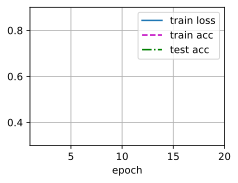

In [143]:
d2l.train_ch3(model, metadata_train_loader, metadata_test_loader, loss, train_epochs, trainer)

In [150]:
obs = torch.tensor(list(df.loc[102][:-1])).reshape(1,1,-1)
obs = obs.to(dtype = torch.float32)

In [151]:
for layer in model:
    obs = layer(obs)
    print(layer.__class__.__name__,'output shape: \t',obs.shape)

Flatten output shape: 	 torch.Size([1, 57])
Linear output shape: 	 torch.Size([1, 50])
Sigmoid output shape: 	 torch.Size([1, 50])
Linear output shape: 	 torch.Size([1, 40])
Sigmoid output shape: 	 torch.Size([1, 40])
Linear output shape: 	 torch.Size([1, 32])
Sigmoid output shape: 	 torch.Size([1, 32])
Linear output shape: 	 torch.Size([1, 28])
Sigmoid output shape: 	 torch.Size([1, 28])
Linear output shape: 	 torch.Size([1, 16])
Sigmoid output shape: 	 torch.Size([1, 16])
Linear output shape: 	 torch.Size([1, 10])
